In [2]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()


# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import src.BikeSeasonalDecomposition as BikeDecomp

import matplotlib.pyplot as plt
from tueplots import bundles
import src.BikeDataPlotter as BikePlotter
import src.EventsDataPlotter as EventsPlotter
import src.Colortheme as ct
import importlib # TODO REMOVE AT FINAL

from src.LoadEventsData import EventsData
from src.LoadEcoCounterData import EcoCounterData as BikeData

In [3]:
bd = BikeData()
ed = EventsData()

In [4]:
bike_data = bd.get_daily_data(None, None, corrected=True, time_as_index=True)

In [5]:
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = .8
plt.rcParams.update({"figure.dpi": 200})
all_years = [year for year in range(2014, 2024)]

In [6]:
def create_seasonal_decomposition(stylesheet, counter_id=None, years=None, weekly_window=None,
                                  custom_data=None, residuals=False, resample_mean=False,
                                  combine_counters=False):
    def set_legend(axes):
            for i,ax in enumerate(axes):
                leg = ax.legend(bbox_to_anchor=(1,1.175), ncol=2, loc="upper right", frameon=False)
                # leg.get_frame().set_linewidth(0.1)
    importlib.reload(ct)
    importlib.reload(BikePlotter)
    importlib.reload(EventsPlotter)
    importlib.reload(BikeDecomp)
    plt.rcParams.update(stylesheet)
    subs = 4 if residuals else 3
    fig_info = plt.subplots(subs, 1, sharex=False)
    event_axis = fig_info[1][:]
    
    combined_c = str.join(' & ', [BikePlotter.COUNTER[c]["name"] for c in counter_id]) if combine_counters else None
        
    to_process_data = custom_data if custom_data is not None else bike_data
    if weekly_window:
        decomp = BikeDecomp.get_seasonal_decomposition(
            to_process_data, years=years, counter_id=counter_id, week_view=True,
            show_window=weekly_window, corr=custom_data is not None, residuals=residuals,
            resample_mean=resample_mean)
        # print(decomp)
        BikePlotter.plot_seasonal_decomposition(
            decomp, fig_info, show_window=weekly_window,
            counter_id=counter_id, xtick_format="week",
            combine_counters=combined_c)
        
    else:
        decomp = BikeDecomp.get_seasonal_decomposition(
            to_process_data, years=years, counter_id=counter_id, week_view=False,
            show_window=weekly_window, corr=custom_data is not None, residuals=residuals,
            resample_mean=resample_mean)
        BikePlotter.plot_seasonal_decomposition(
            decomp, fig_info, counter_id=[counter_id], xtick_format="year",
            combine_counters=combined_c)
        
    if years is None:
        years = all_years
    if weekly_window is None:
        EventsPlotter.plot_school_breaks(ed, years, event_axis)
        EventsPlotter.plot_covid(ed, years, event_axis, show_abbr=False)
        set_legend(fig_info[1])
    plt.show()

# Week Analysis

In this analysis, our attention shifts to a weekly perspective.

Following insights from the previous evaluation (`eva_2_TrendAnalysis.ipynb`), we combine data from the Fahrradtunnel and Steilachallee counters by calculating the hourly mean.\
If a comparison with Hirschau is of interest, it will be examined separately.

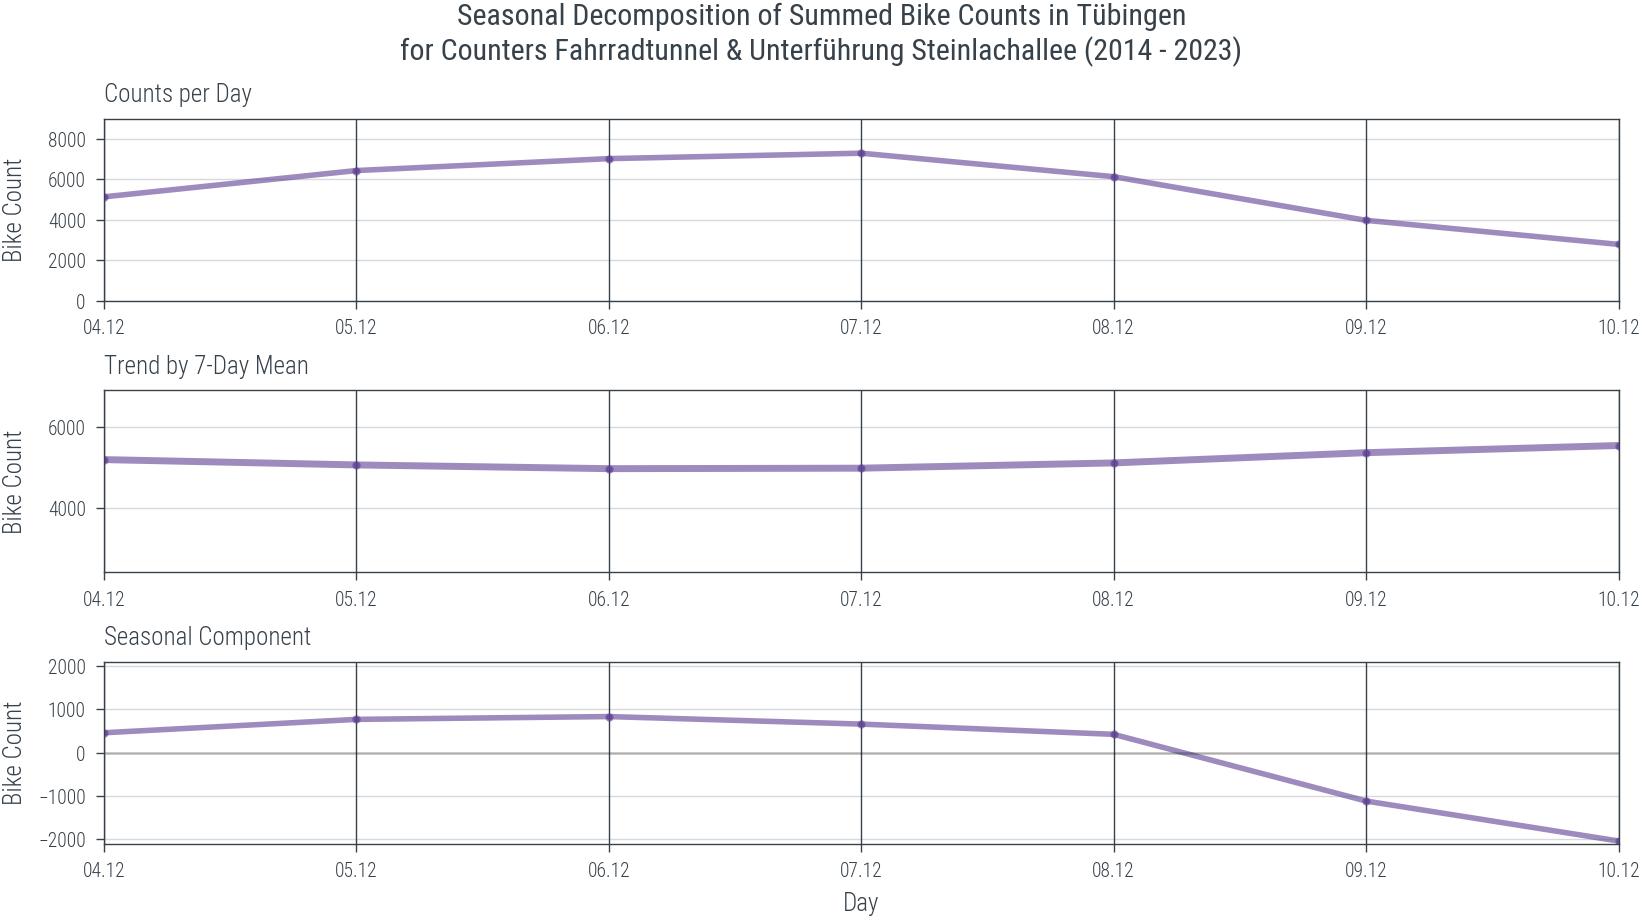

In [7]:
# seasonal decomposition with 7 day window for the mean of the counters Fahrradtunnel and Steilachallee
StYLE_4_SUBS = bundles.beamer_moml(rel_width=2, rel_height=2)
StYLE_3_SUBS = bundles.beamer_moml(rel_width=1.5, rel_height=1.5)
week_to_look_at = [pd.Timestamp("2023-12-04"), pd.Timestamp("2023-12-10")]
create_seasonal_decomposition(StYLE_3_SUBS, counter_id=[100003358, 100003359], resample_mean=True, weekly_window=week_to_look_at, combine_counters=True)

__Observation__:
- Monday to Friday the counts are much higher than on the weekend
- working days show a slight curvature with a peak on Wednesday. This is might be connected to people working from home on Monday and Friday
- Saturday has more counts than Sunday. This is probably due to people going shopping on Saturdays or doing bike tours. 
- there might be a small amount of people going to work on Saturday
- a huge impact for the decrease of counts on the weekends might also be pupil and students who do not go to school or university
- Sundays has the lowest counts, as shopping is not possible and even less people go to work

Let's compute the mean per weekday for the counters Fahrradtunnel and Steinlachalle and plot it, compared to Hirschau. Also, divide the data into summer and winter, to compare seasonal differences. We define summer as the combination of the meteorological seasons spring and summer and winter as the combination of autumn and winter, i.e.: summer = March to August, winter = September to February.

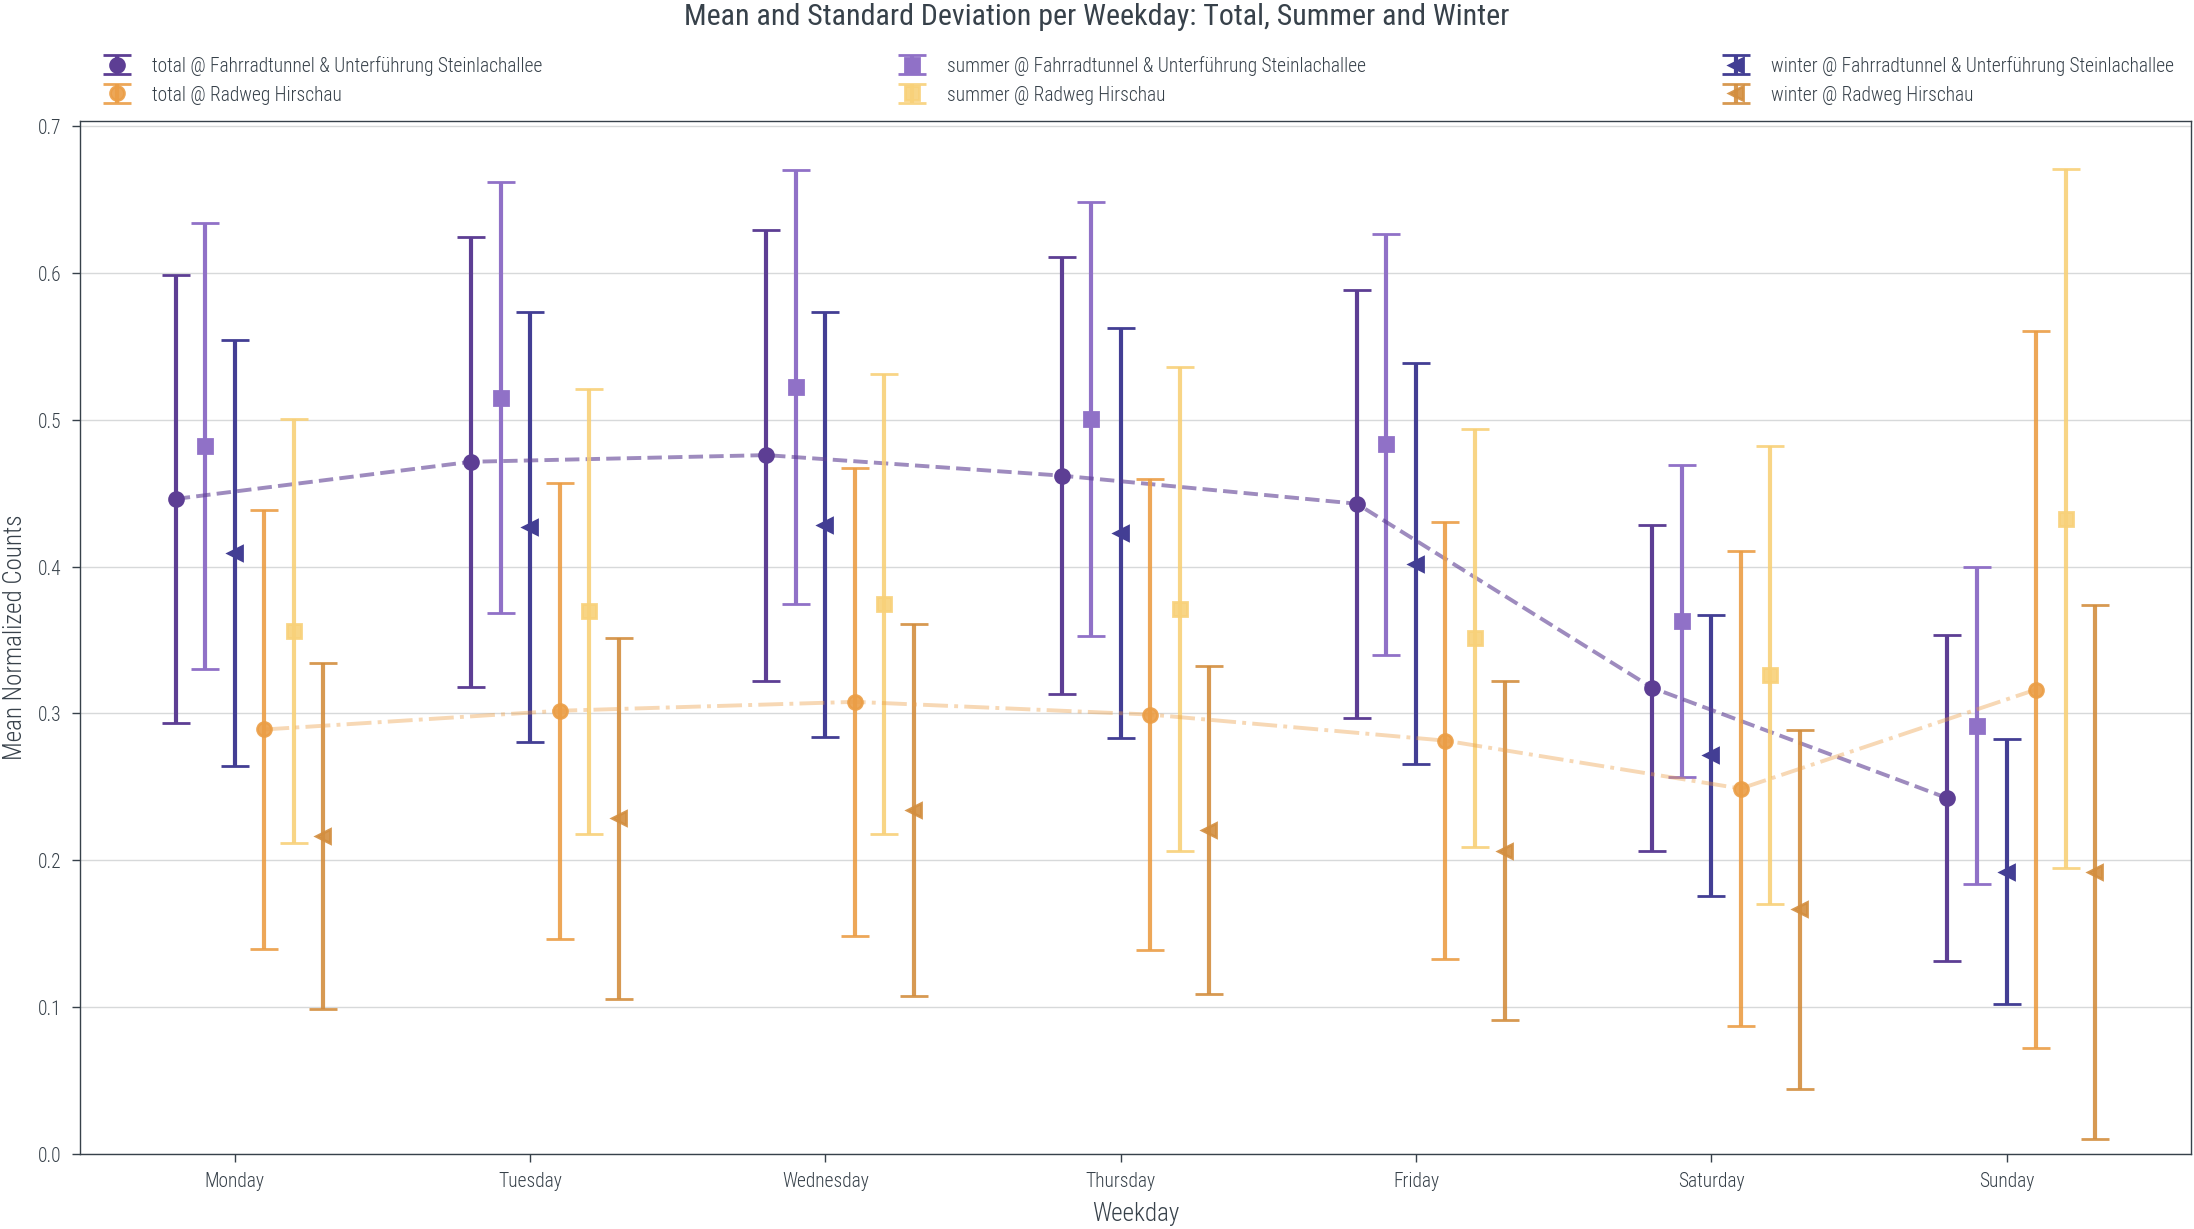

In [16]:
# get corrected data
df = bd.get_daily_data()

# separate Fahrradtunnel and Steilachallee from Hirschau
df_city = df[df["counter_site_id"].isin([100003358, 100003359])].copy()
df_hirschau = df[df["counter_site_id"].isin([100026408])].copy()
df_city = df_city.groupby(["iso_timestamp", "weekday"])["zählstand"].mean().reset_index()

df_city["zählstand"] /= df_city["zählstand"].max()
df_hirschau["zählstand"] /= df_hirschau["zählstand"].max()
# extract seasons per counter
# city
df_city_summer = df_city[(df_city["iso_timestamp"].dt.month >= 3) & (df_city["iso_timestamp"].dt.month <= 8)].copy()
df_city_winter = df_city[(df_city["iso_timestamp"].dt.month >= 9) | (df_city["iso_timestamp"].dt.month <= 2)].copy()

# hirschau
df_hirschau_summer = df_hirschau[(df_hirschau["iso_timestamp"].dt.month >= 3) & (df_hirschau["iso_timestamp"].dt.month <= 8)].copy()
df_hirschau_winter = df_hirschau[(df_hirschau["iso_timestamp"].dt.month >= 9) | (df_hirschau["iso_timestamp"].dt.month <= 2)].copy()

# compute mean and std over weekdays
# city
df_city_weekday = df_city.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_city_summer_weekday = df_city_summer.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_city_winter_weekday = df_city_winter.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()

# Hirschau
df_hirschau_weekday = df_hirschau.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_hirschau_summer_weekday = df_hirschau_summer.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()
df_hirschau_winter_weekday = df_hirschau_winter.groupby("weekday")["zählstand"].agg(["mean", "std"]).reset_index()

lst_city = [df_city_weekday, df_city_summer_weekday, df_city_winter_weekday]
lst_hirschau = [df_hirschau_weekday, df_hirschau_summer_weekday, df_hirschau_winter_weekday]
season = ["total", "summer", "winter"]
data = [lst_city, lst_hirschau]

# plot
plt.rcParams.update(StYLE_4_SUBS)
fig, ax = plt.subplots()
offset_sz = .3
season_color = {
        0: [BikePlotter.COUNTER["FSC"]["color"], BikePlotter.COUNTER[100026408]["color"]],    # COUNTERS
        1: [BikePlotter.COUNTER["FSC"]["color"]+0.2, BikePlotter.COUNTER[100026408]["color"]+[0.05,0.2,0.2]], # SUMMER
        2: [BikePlotter.COUNTER["FSC"]["color"]+[-.1,0,0], BikePlotter.COUNTER[100026408]["color"]*0.9]     # WINTER
}
marker_style = {
    0: "o",
    1: "s",
    2: "<"
}
for didx, d in enumerate(data):
    for sidx, s in enumerate(season):
        weekday_df = data[didx][sidx]
        
        # offset for plotting
        weekday_df["weekday"] -= (offset_sz * len(data)) / len(season)
        weekday_df["weekday"] += offset_sz * (didx + (sidx / len(season)))

        counter = "FSC" if didx == 0 else 100026408
        alpha = 1 if didx == 0 else 0.9
        
        ax.errorbar(
            weekday_df["weekday"],
            weekday_df["mean"],
            yerr=weekday_df["std"],
            fmt=marker_style[sidx],
            ms=5, lw=1.5,
            capsize=5,
            label=f"{s} @ {BikePlotter.COUNTER[counter]['name']}",
            color=season_color[sidx][didx],
            alpha=alpha
        )
        
    ax.plot(
        d[0]["weekday"],
        d[0]["mean"],
        color=season_color[0][didx],
        alpha=0.6 if didx == 0 else 0.4, lw=1.4,
        linestyle="--" if didx == 0 else "-.",
    )
        
fig.suptitle("Mean and Standard Deviation per Weekday: Total, Summer and Winter")
ax.set_xlabel("Weekday")
ax.set_ylabel("Mean Normalized Counts")
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.grid(axis="y")
ax.set_ylim(bottom=0)
handles, labels = ax.get_legend_handles_labels()
order = [0,3,1,4,2,5]
new_labels_order = [labels[idx] for idx in order]
# new_labels_order.insert(0,custom_legend[1])
new_handles_order = [handles[idx] for idx in order]
plt.legend(new_handles_order, new_labels_order , bbox_to_anchor=(0,1.08,1,0), mode="expand", ncol=3, loc="upper center", frameon=False)
plt.show()

__Observation__:
- we can confirm the observations from the seasonal decomposition. At the counters Fahrradtunnel and Steinlachallee the counts are much higher on working days than on the weekend
- we can also see the slight curvature with a peak on Wednesday and the decrease on the weekend with more counts on Saturday than on Sunday.
- the seasonal shift is also visible. In summer the counts are higher than in winter. The difference over the weekdays and years will be analyzed in the next section
- Hirschau shows a curvature over weekdays as well, so there might be an effect of people cycling to work, school or university from Hirschau 
- the weekend is interesting, because the counts are higher on Sunday than on Saturday and also higher than the means of the weekdays 
- at Hirschau, on weekends the difference between summer and winter diverges more than on working days. This strengthens the assumption that people cycle to Hirschau for leisure activities on the weekends. Furthermore, this happens in summer, as the weather is better then

## Deviation from Summer to Winter per Weekday

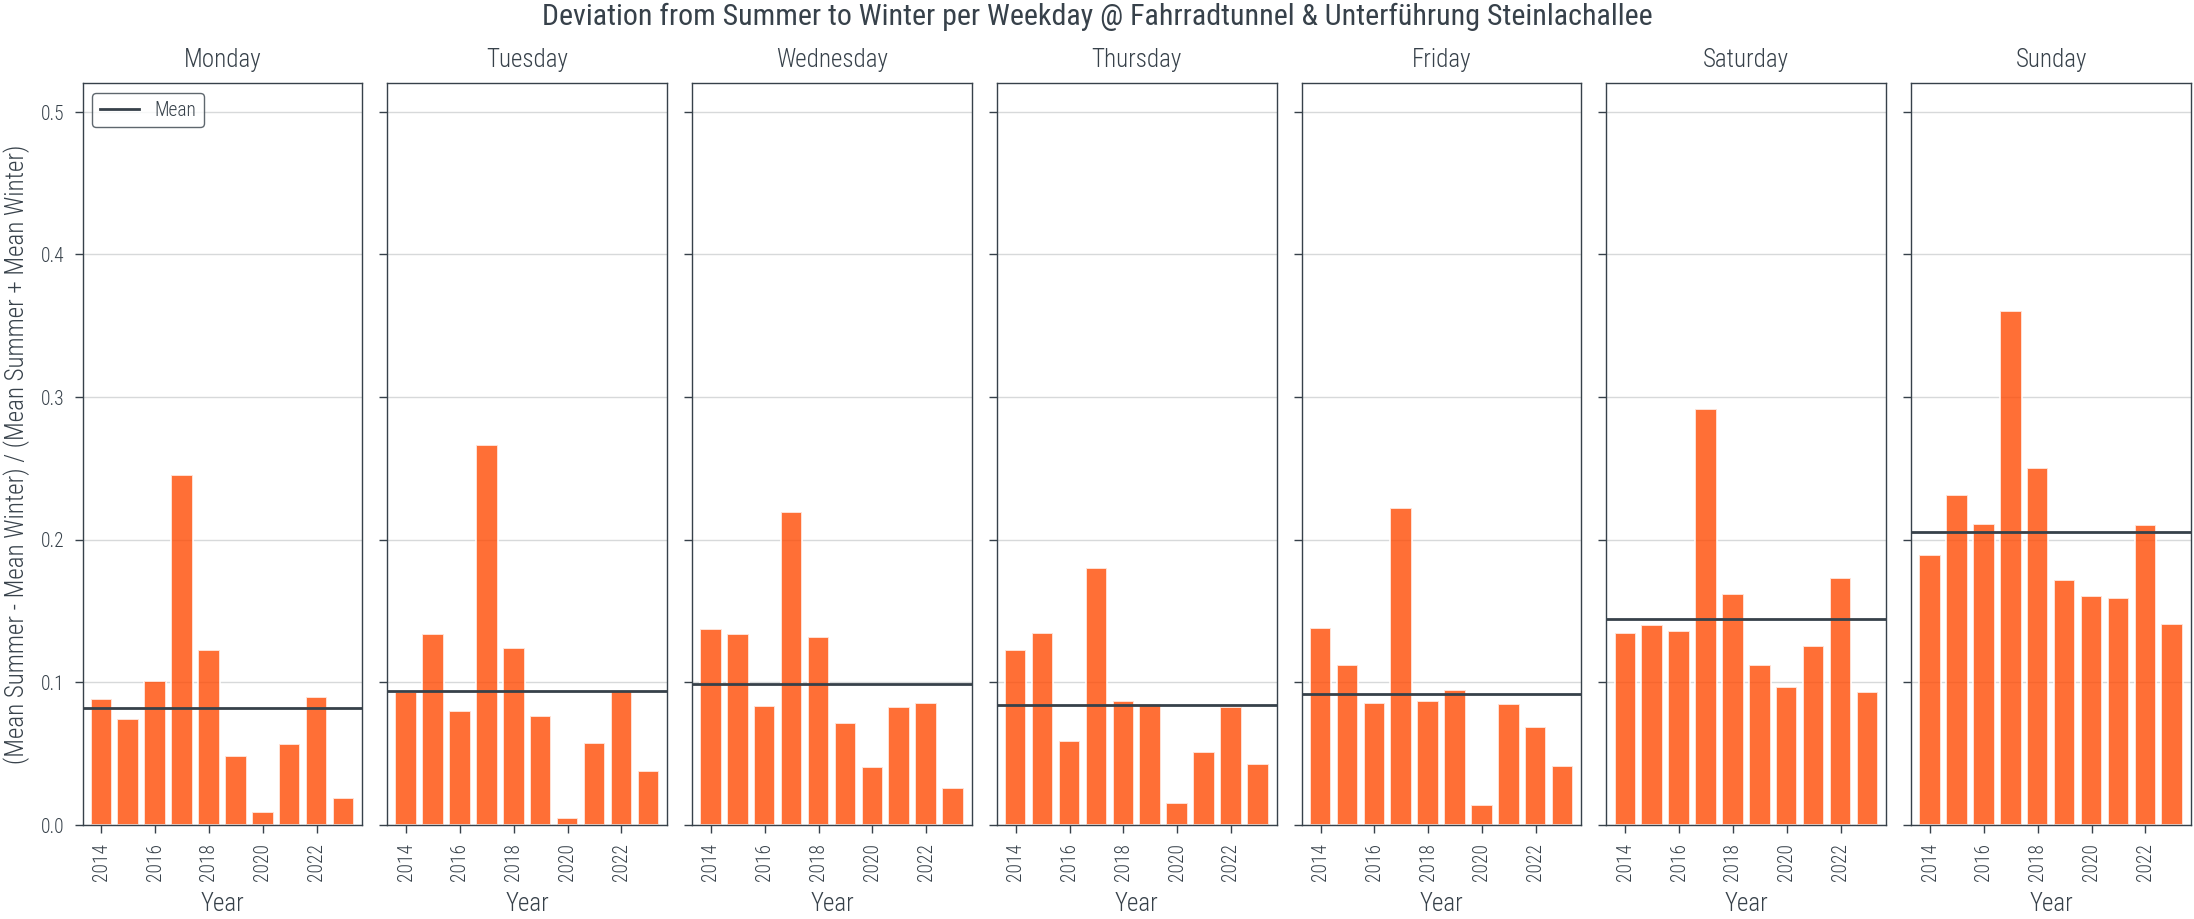

In [35]:
df_city_summer["iso_timestamp"] = pd.to_datetime(df_city_summer["iso_timestamp"])
df_city_winter["iso_timestamp"] = pd.to_datetime(df_city_winter["iso_timestamp"])

years = df_city_summer["iso_timestamp"].dt.year.unique()
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

season_color = {
        0: [BikePlotter.COUNTER["FSC"]["color"], BikePlotter.COUNTER[100026408]["color"]],
        1: [ct.SUMMER_COLOR, ct.SUMMER_COLOR],
        2: [ct.WINTER_COLOR, ct.WINTER_COLOR]
}

plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=1.5))
fig, ax = plt.subplots(1, 7, sharey=True)

for wd_idx in range(7): # weekdays
    df_summer_weekday = df_city_summer[df_city_summer["weekday"] == wd_idx]
    df_winter_weekday = df_city_winter[df_city_winter["weekday"] == wd_idx]
    
    for year in years:
        df_summer_weekday_year = df_summer_weekday[df_summer_weekday["iso_timestamp"].dt.year == year]
        df_winter_weekday_year = df_winter_weekday[df_winter_weekday["iso_timestamp"].dt.year == year]
        
        # mean per year
        summer_mean = df_summer_weekday_year["zählstand"].mean()
        winter_mean = df_winter_weekday_year["zählstand"].mean()
        
        ax[wd_idx].bar(
            year,
            (summer_mean - winter_mean) / (summer_mean + winter_mean),
            color=season_color[1][0] if summer_mean > winter_mean else season_color[2][0],
            edgecolor="white",
            lw=0.7,
            width=0.8,
            label="_nolegend_",
            alpha=0.8
        )
    
    # display average
    mean = (df_summer_weekday["zählstand"].mean() - df_winter_weekday["zählstand"].mean()) / (df_summer_weekday["zählstand"].mean() + df_winter_weekday["zählstand"].mean())
    ax[wd_idx].plot(
        [min(years)-0.7, max(years)+0.7],
        [mean, mean],
        color=ct.NEUTRAL_COLORS[0],
        lw=1
    )
    
    ax[wd_idx].title.set_text(days[wd_idx])
    ax[wd_idx].set_ylim(0, 0.52)
    ax[wd_idx].set_xlim(min(years)-0.7, max(years)+0.7)
    ax[wd_idx].set_xlabel("Year")
    ax[wd_idx].grid(axis="y")
    ax[wd_idx].set_xticks(range(min(years), max(years) + 1, 2))
    ax[wd_idx].set_xticklabels(range(min(years), max(years) + 1, 2), rotation=90)
    ax[0].legend(["Mean"], loc="upper left")
plt.suptitle(f"Deviation from Summer to Winter per Weekday @ {BikePlotter.COUNTER['FSC']['name']}")
ax[0].set_ylabel("(Mean Summer - Mean Winter) / (Mean Summer + Mean Winter)")
plt.show()

__Observation__:
- the seasonal differences are not constant over the years on weekdays. This is probably due to different weather conditions over the years
- clearly visible is the impact of the pandemic in 2020. The difference between summer and winter is much smaller than in the years before. This is probably due to the fact that people work from home and do not go to school or university
- the difference on the weekend remains relatively constant over the years
- but on average the difference between summer and winter over the weekdays is relatively small

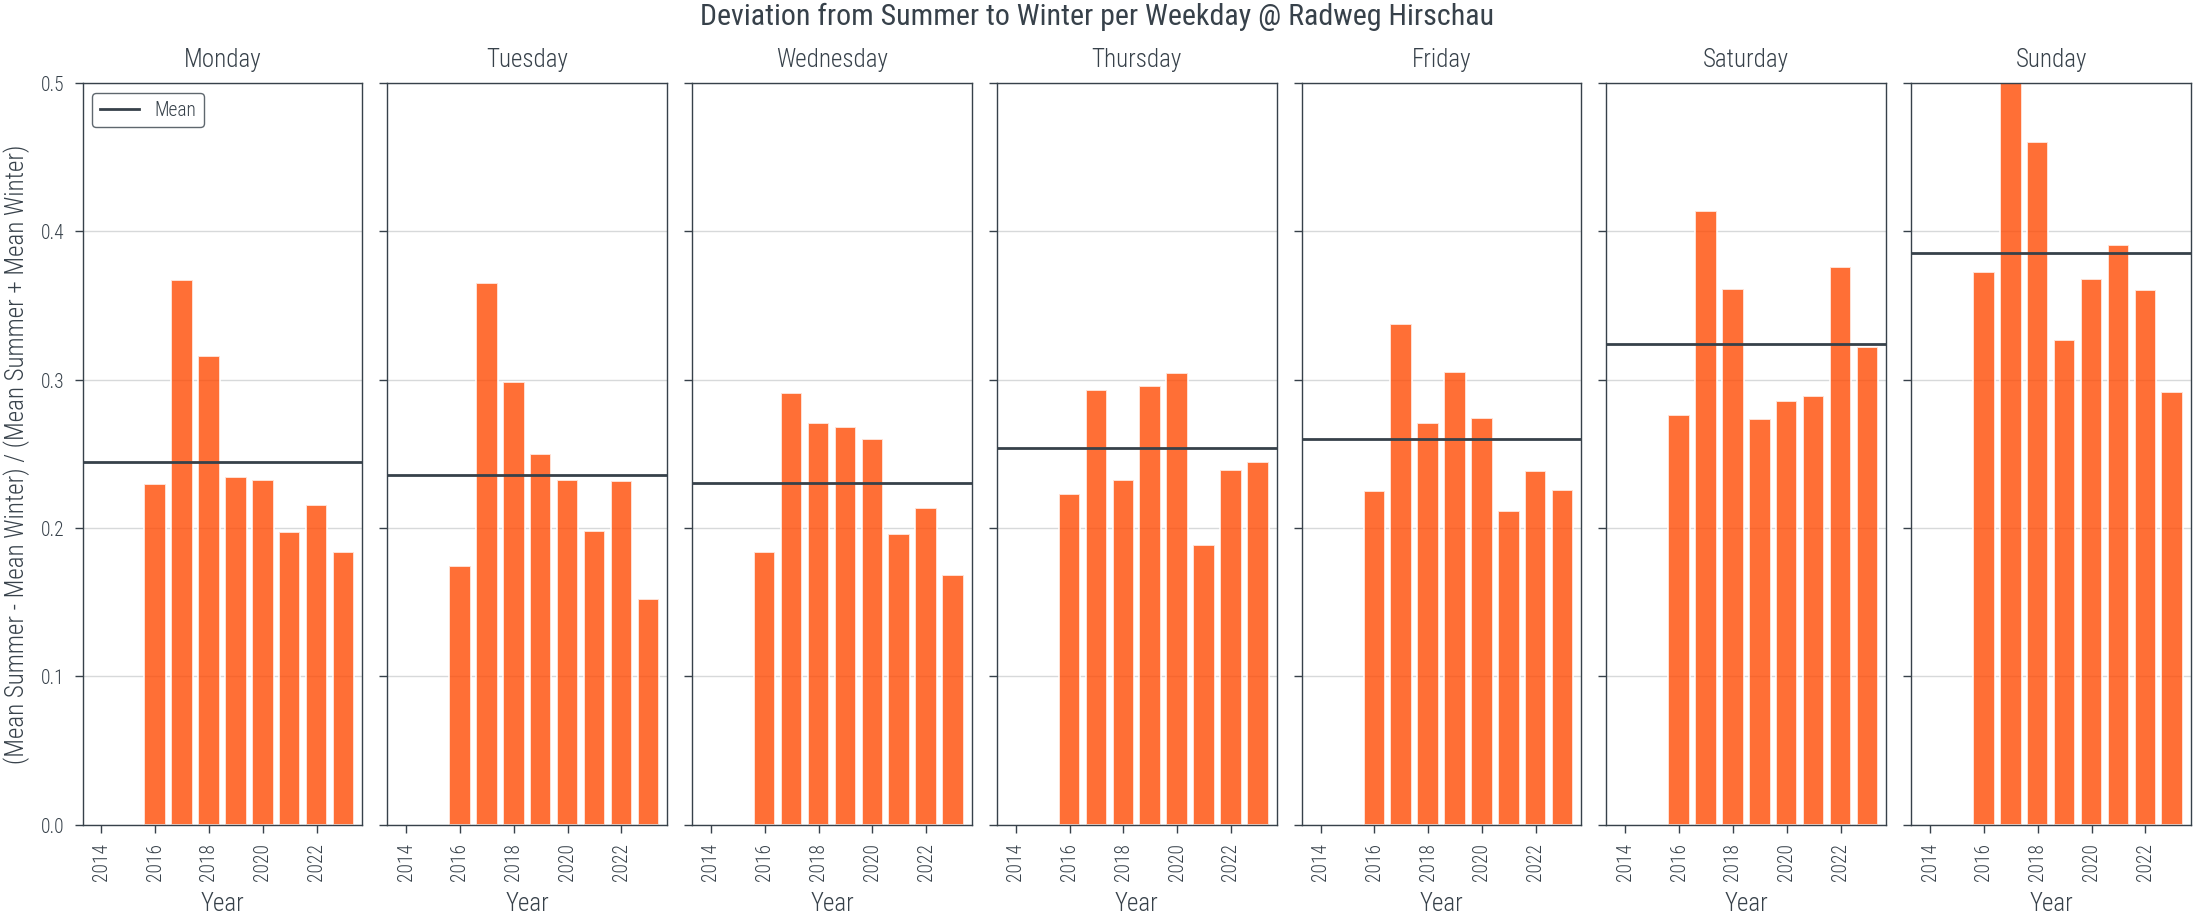

In [34]:
df_hirschau_summer["iso_timestamp"] = pd.to_datetime(df_hirschau_summer["iso_timestamp"])
df_hirschau_winter["iso_timestamp"] = pd.to_datetime(df_hirschau_winter["iso_timestamp"])


fig, ax = plt.subplots(1, 7, sharey=True)

for wd_idx in range(7): # weekdays
    df_summer_weekday = df_hirschau_summer[df_hirschau_summer["weekday"] == wd_idx]
    df_winter_weekday = df_hirschau_winter[df_hirschau_winter["weekday"] == wd_idx]
    
    for year in years:
        df_summer_weekday_year = df_summer_weekday[df_summer_weekday["iso_timestamp"].dt.year == year]
        df_winter_weekday_year = df_winter_weekday[df_winter_weekday["iso_timestamp"].dt.year == year]
        
        # mean per year
        summer_mean = df_summer_weekday_year["zählstand"].mean()
        winter_mean = df_winter_weekday_year["zählstand"].mean()
        
        ax[wd_idx].bar(
            year,
            (summer_mean - winter_mean) / (summer_mean + winter_mean),
            color=season_color[1][0] if summer_mean > winter_mean else season_color[2][0],
            edgecolor="white",
            lw=0.7,
            width=0.8,
            label="_nolegend_",
            alpha=0.8
        )
    
    # display average
    mean = (df_summer_weekday["zählstand"].mean() - df_winter_weekday["zählstand"].mean()) / (df_summer_weekday["zählstand"].mean() + df_winter_weekday["zählstand"].mean())
    ax[wd_idx].plot(
        [min(years)-0.7, max(years)+0.7],
        [mean, mean],lw=1,
        color=ct.NEUTRAL_COLORS[0],
        # lw=1,
    )
    
    ax[wd_idx].title.set_text(days[wd_idx])
    ax[wd_idx].set_ylim(0, 0.5)
    ax[wd_idx].set_xlim(min(years)-0.7, max(years)+0.7)
    ax[wd_idx].set_xlabel("Year")
    ax[wd_idx].grid(axis="y")
    ax[wd_idx].set_xticks(range(min(years), max(years) + 1, 2))
    ax[wd_idx].set_xticklabels(range(min(years), max(years) + 1, 2), rotation=90)
    ax[0].legend(["Mean"], loc="upper left")
plt.suptitle(f"Deviation from Summer to Winter per Weekday @ {BikePlotter.COUNTER[100026408]['name']}")
ax[0].set_ylabel("(Mean Summer - Mean Winter) / (Mean Summer + Mean Winter)")
plt.show()

__Observation__:
- in total the difference between summer and winter is much higher than at the counters Fahrradtunnel and Steilachallee
- on weekends the mean difference rises to its maximum on Sundays. This strengthens the assumption that people cycle to Hirschau on the weekend for leisure activities and this happens in summer, as the weather is better then
- Covid is not clearly visible in the data

## Overall Observations and Conclusion
- the weekly pattern leads to the hypothesis, that the major amount of the counted cyclists are commuters, heading to work, school or university. Especially the counter data of Fahrradtunnel and Steilachallee show this pattern, as on weekends the counts are much lower than on working days
- working people might tend to work from home on Monday and Friday, which may lead to the slight curvature with a peak on Wednesday
- at Hirschau counter, the ratio of commuters to people who cycle for leisure activities is probably lower than at the counters Fahrradtunnel and Steilachallee. Therefore, the differences from winter to summer are much higher at Hirschau than at the other counters
- From the differences from winter to summer at the city counters, we can conclude that the typical Tübingen cyclist is not deterred by winter season weather conditions. An analysis of the weather data could confirm this hypothesis
- weekdays appear to have a relatively similar pattern over the days. It might be interesting to analyse differences between Monday, Tuesday, Wednesday, Thursday and Friday, and retrieve some insights about the working habits of the people in Tübingen
- As weekends are entirely different from weekdays, they should be analyzed separately. It might be interesting to analyze the differences between an average weekday and weekend day.